In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as pl
import seaborn as sns
from seaborn import set_style, pairplot, swarmplot,boxplot
set_style(None)

/Users/utkarshagrawal/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/utkarshagrawal/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from scipy.special import factorial
## Sklearn packages
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import LinearRegression, PoissonRegressor, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score, precision_recall_fscore_support

## statsmodel packages
import statsmodels.api as sm

from helper_functions import addline

In [4]:
def prepare_train_X(X,y):
    X['possession_per_pass'] = X['possession']/X['passes']

    X['xg_per_shot'] = X['xg'] / X['shots_on_target']
    X.loc[X['xg_per_shot']==np.inf,'xg_per_shot'] = 0

    X['quality_of_shots'] = X['shots_on_target'] / X['shots']
    X.loc[X['shots']==0,'quality_of_shots']=0

    X['opp_xg_per_shot'] = X['opp_xg']/ X['opp_shots']
    X.loc[X['opp_xg_per_shot']==np.inf,'opp_xg_per_shot'] = 0

    X['opp_quality_of_shots'] = X['opp_shots_on_target'] / X['opp_shots']
    X.loc[X['opp_shots']==0,'opp_quality_of_shots']=0

    X = X.drop(columns=['goals','passes','opp_passes','xg','opp_xg','shots','opp_shots'])

    X['Loss'] = 0
    X.loc[(X['Win']==0) * (X['Draw']==0),'Loss'] = 1

    X['win_opp_goals'] = X['Win'] * X['opp_goals']

    ## Goals = 6 only occur 4 times. Thus these points have high leverage and we need to remove them
    X = X[y<6]
    y = y[y<6]
    y = y[X['opp_goals']<6]
    X = X.loc[X['opp_goals']<6]

    return X,y


def mean_goals(probs,goal_range=np.arange(0,6,1)):
    return np.sum(probs*goal_range,axis=-1)

In [5]:
home_data = pd.read_csv('data/home_data_18_19.csv',index_col=0)
away_data = pd.read_csv('data/away_data_18_19.csv',index_col=0)
home_data.head()

,goals,passes,possession,shots,shots_on_target,xg,opp_goals,opp_passes,opp_shots,opp_shots_on_target,opp_xg,Win,Draw
0,2,485.0,46.3,8.0,6.0,1.25,1,543.0,13.0,4.0,1.46,1,0
1,0,773.0,71.7,12.0,5.0,1.54,1,303.0,11.0,5.0,1.27,0,0
2,0,420.0,38.3,11.0,5.0,1.30,2,675.0,15.0,6.0,1.63,0,0
3,1,313.0,35.4,15.0,6.0,1.57,5,579.0,12.0,7.0,1.62,0,0
4,3,553.0,55.1,21.0,7.0,2.15,1,473.0,8.0,5.0,1.15,1,0


In [6]:
X = pd.DataFrame({'intercept':np.ones(home_data.shape[0] + away_data.shape[0])})
cols = home_data.columns
for col in cols:
    X[col] = list(home_data[col]) + list(away_data[col])
y = X['goals']

X,y = prepare_train_X(X,y)

y.shape

(752,)

In [8]:
log_cols = ['shots_on_target','opp_shots_on_target','possession']
log_class = LogisticRegression()
X_log = X[log_cols]
y_log = np.ones(len(X))
y_log[X['Win']==1] = 0
y_log[X['Loss']==1] = 1
y_log[X['Draw']==1] = 2

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log,y_log,test_size=0.2,shuffle=True,random_state=20)

scaler = StandardScaler(copy=True)
scaler = scaler.fit(X_train_log)
X_train_log = scaler.transform(X_train_log)
X_test_log = scaler.transform(X_test_log)
log_res = log_class.fit(X_train_log,y_train_log)

In [9]:
print('Training error:', np.mean(log_class.predict(X_train_log) == y_train_log))
print('')
print('Testing error:', np.mean(log_class.predict(X_test_log) == y_test_log))

Training error: 0.6422628951747088

Testing error: 0.6026490066225165


[[187  49  56]
 [ 55 199  55]
 [  0   0   0]]


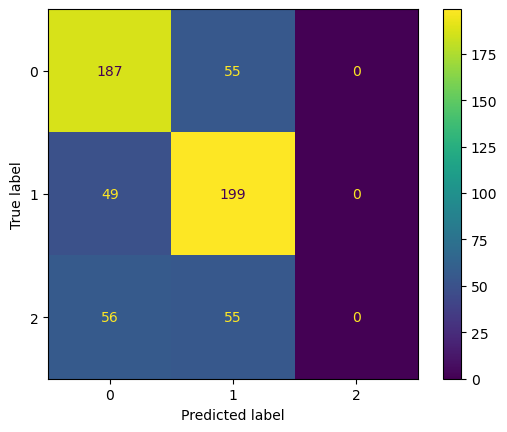

In [10]:
cm = sk.metrics.confusion_matrix(log_class.predict(X_train_log),y_train_log,labels=[0,1,2])
print(cm)
sk.metrics.ConfusionMatrixDisplay.from_predictions(y_train_log,log_class.predict(X_train_log),labels=[0,1,2])